In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random
from io import BytesIO

import scipy.misc
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("device=", device)

device= cuda


In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [3]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [5]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

saving data/all_codones.pickle


In [5]:
def sample_generator(all_codnums, context_window_size, vocab_size, num_neg_samples):
    """ Form training pairs according to the skip-gram model. """
    for cod_nums in all_codnums:
#         print("new line len=", len(cod_nums))
        for i, center in enumerate(cod_nums):

            targets = cod_nums[max(0, i - context_window_size): i + context_window_size + 1]

            for target in targets:
                negatives = torch.zeros(num_neg_samples, dtype=torch.long).to(device)
                for j in range(num_neg_samples):
                    negative = center
                    while negative in targets:
                        negative = random.randint(0, vocab_size - 1)
                    negatives[j] = negative
                yield center, target, negatives
                
def batch_generator(sample_gen, batch_size,num_neg_samples):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = torch.zeros(batch_size, dtype=torch.long).to(device)
        target_batch = torch.zeros(batch_size, dtype=torch.long).to(device)
        negative_batch = torch.zeros(batch_size, num_neg_samples, dtype=torch.long).to(device)

        for i in range(batch_size):
            center_batch[i], target_batch[i], negative_batch[i] = next(sample_gen)
        yield center_batch, target_batch, negative_batch

def process_data(all_codnums, batch_size, skip_window, vocab_size, num_neg_samples):
    # 3grams replaced by nums
    sample_gen = sample_generator(all_codnums, skip_window, vocab_size, num_neg_samples)
    batch_gen = batch_generator(sample_gen, batch_size, num_neg_samples)
    return batch_gen  # returns batches of center_3gram_num, target_3gram_num, 5 x negative_3gram_nums (num in terms ix in vocabulary)7

In [6]:
def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

In [7]:
dictionary = read_or_create(read_path="data/dictionary.pickle",
                            producer=lambda:make_dictionary(all_codones))

reading data/dictionary.pickle


In [8]:
vocab_size = len(dictionary.keys())
vocab_size

9424

In [9]:
all_codnums = read_or_create(read_path="data/all_codnums.pickle",
                             producer=lambda: [cod_to_dict(cod, dictionary) for cod in all_codones])

reading data/all_codnums.pickle


In [23]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, batch_size):
        super(SkipGram, self).__init__()
        self.batch_size = batch_size

        self.embed_center = nn.Embedding(vocab_size, embedding_dim, sparse=True).to(device)
        self.embed_context = nn.Embedding(vocab_size, embedding_dim, sparse=True).to(device)

        self.embed_center.weight.data.uniform_(-0.2, 0.2)
        self.embed_context.weight.data.uniform_(-0.2, 0.2)

    def forward(self, center, target, negative):
        center_vec = self.embed_center(center)
        target_vec = self.embed_context(target)
        neg_vec = self.embed_context(negative)

        center_vec = center_vec.unsqueeze(2)
        target_vec = target_vec.unsqueeze(1)

        # print(center_vec.shape, target_vec.shape, neg_vec.shape)

        tar_score = -torch.bmm(target_vec, center_vec)
        tar_score = F.logsigmoid(tar_score)

        neg_score = torch.bmm(neg_vec, center_vec)
        neg_score = F.logsigmoid(neg_score)

        loss = -(tar_score + neg_score)
        # print(tar_score.shape, neg_score.shape, loss.shape)
        loss = loss.sum()/self.batch_size

        return loss


In [53]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window
learning_rate = 2
EMBEDDING_DIM = 100
NUM_NEG_SAMPLES = 5
BATCHES_TO_PROCESS = 100_000
PRINT_LOSS_EACH = 100
SAVE_WEIGHTS_EACH = 1000
WEIGHTS_PATH = "weights.pth"
ALL_CODNUMS_PATH = "data/all_codnums.pickle"
LOAD_FROM_WEIGHTS = True
TRAIN = False

batch_gen = process_data(all_codnums, BATCH_SIZE, SKIP_WINDOW, vocab_size, NUM_NEG_SAMPLES)

model = SkipGram(vocab_size, EMBEDDING_DIM, BATCH_SIZE)
if LOAD_FROM_WEIGHTS:
    model.load_state_dict(torch.load(WEIGHTS_PATH))

# optimizer = optim.Adagrad(model.parameters())
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []

if TRAIN:
    print("starting to train...")
    for i_batch in range(BATCHES_TO_PROCESS):

        center_batch, target_batch, negative_batch = next(batch_gen)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        loss = model(center_batch, target_batch, negative_batch)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if i_batch % PRINT_LOSS_EACH == 0:
            print("batch", i_batch, f"loss= {sum(losses[-PRINT_LOSS_EACH:]) / PRINT_LOSS_EACH:.5}")

        if i_batch % SAVE_WEIGHTS_EACH == 0:
            torch.save(model.state_dict(), WEIGHTS_PATH)
    

In [70]:
def create_embed_matrix(model):
    keys = torch.tensor(range(vocab_size), dtype=torch.long).to(device)
    embed_matrix = model.embed_center(keys).cpu().detach().numpy()
    return embed_matrix

In [71]:
final_embed_matrix = create_embed_matrix(model)


In [73]:
tsne = TSNE(n_components=2, random_state=42)
XX = read_or_create("data/XX.pickle",
                    lambda:tsne.fit_transform(final_embed_matrix))

saving data/XX.pickle


In [74]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,10.119790,-25.699995,YHF
1,22.339340,-7.535761,GFP
2,-4.313443,-59.990273,SHG
3,-35.666725,4.016198,RMQ
4,-3.456163,-36.440979,QYC


In [75]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

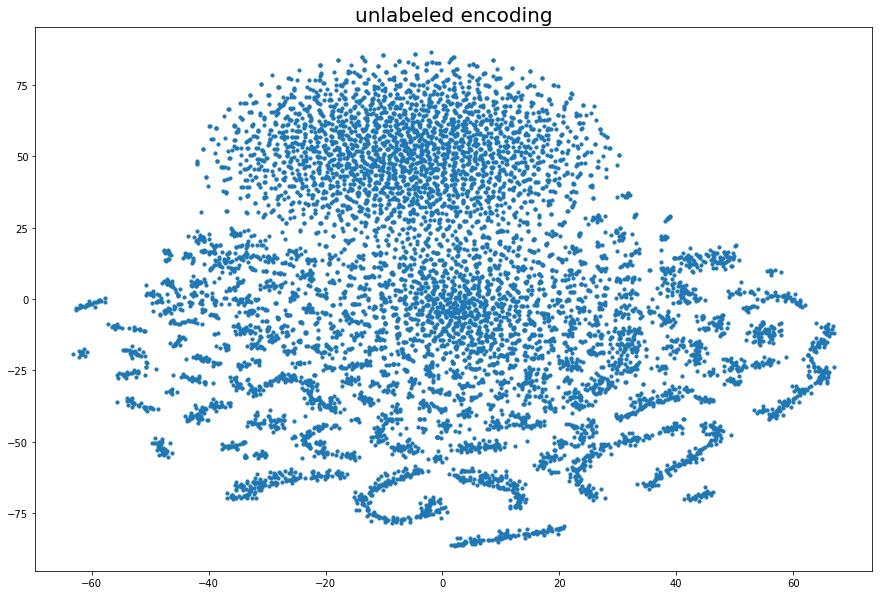

In [76]:
plot_tsne_df(tsne_df)

In [77]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [78]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [79]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [80]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,YHF,-0.566667,149.162167,22.333333,178.900000
1,GFP,0.266667,100.446800,16.666667,120.900000
2,SHG,-1.466667,93.755967,14.666667,100.766667
3,RMQ,-2.033333,138.503667,22.000000,160.033333
4,QYC,-0.766667,131.481800,19.333333,148.633333


In [81]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,YHF,-0.566667,149.162167,22.333333,178.900000,10.119790,-25.699995
1,GFP,0.266667,100.446800,16.666667,120.900000,22.339340,-7.535761
2,SHG,-1.466667,93.755967,14.666667,100.766667,-4.313443,-59.990273
3,RMQ,-2.033333,138.503667,22.000000,160.033333,-35.666725,4.016198
4,QYC,-0.766667,131.481800,19.333333,148.633333,-3.456163,-36.440979


In [86]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

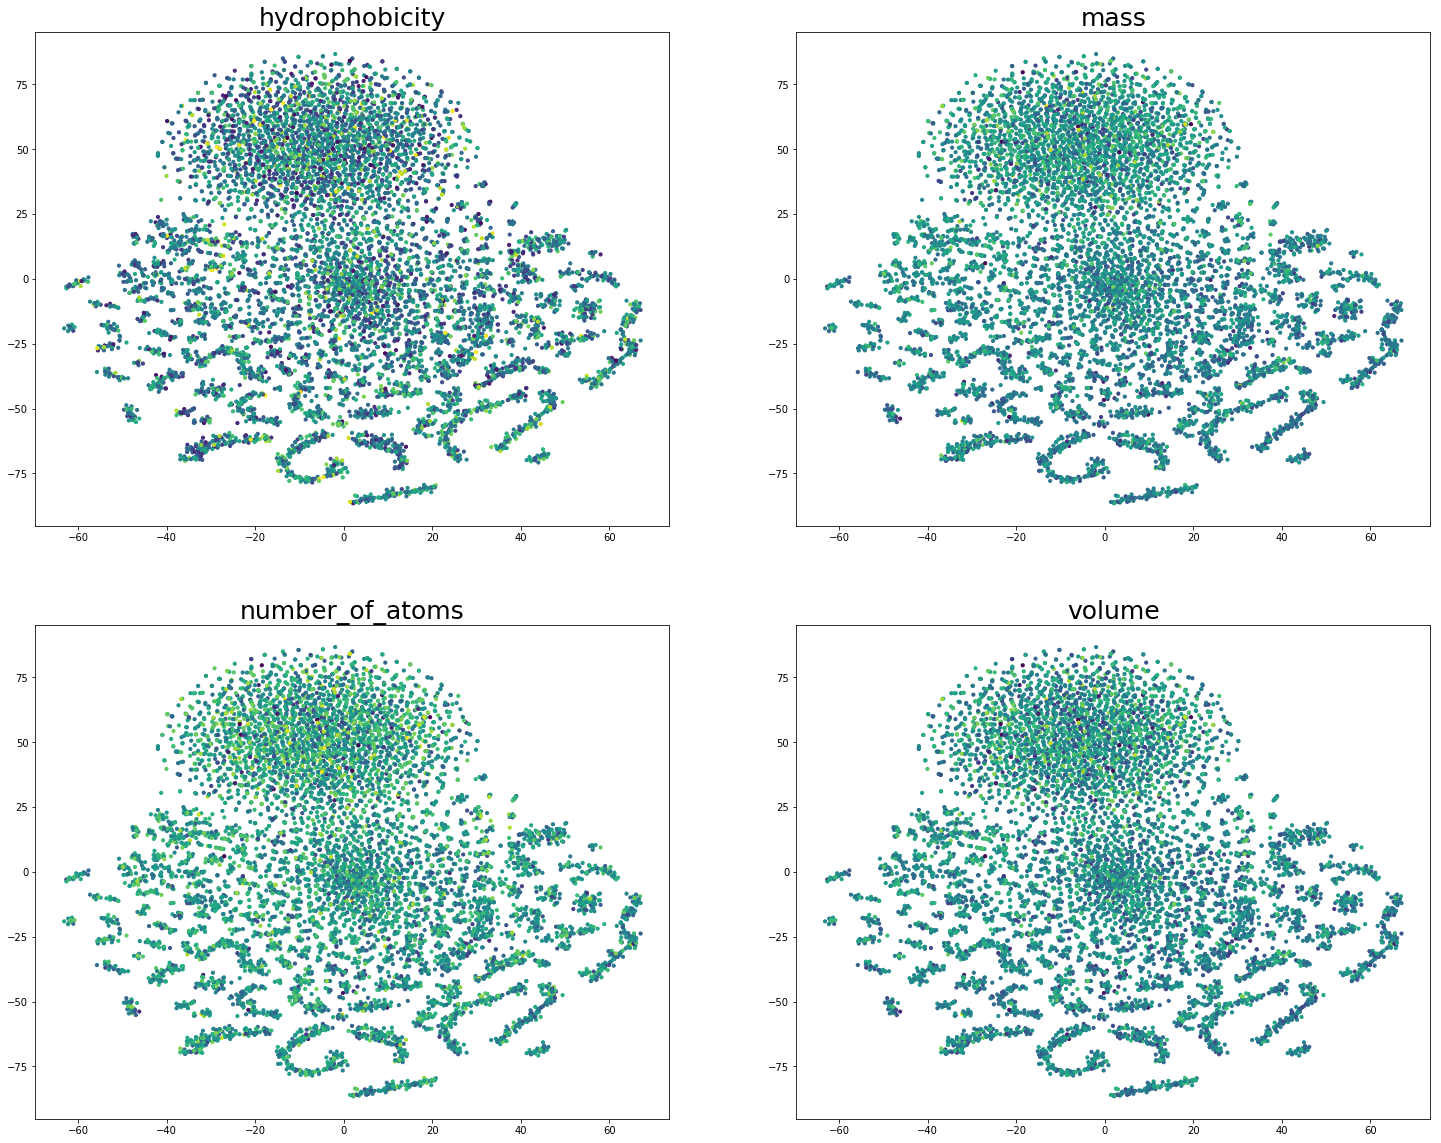

In [87]:
plot_embedding_properties(final_df)

In [89]:
from  tensorboardX  import SummaryWriter

writer = SummaryWriter(log_dir="logs_tsne")
writer.add_embedding(final_embed_matrix, tag="embeddings")
writer.close()